In [18]:
# preamble

from pathlib import Path
from multiprocessing import Pool
import socket
import pickle
from datetime import datetime
from time import time
from os import path, makedirs, chmod
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import meep as mp
import meep.materials as mats
from meep import mpb
import meep.adjoint as mpa
# import meeputils as mu
from wurlitzer import pipes, STDOUT
from io import StringIO
# from pint import UnitRegistry
# u = UnitRegistry()

from scipy.interpolate import RectBivariateSpline
# my additions
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy.optimize as opt
import warnings
import h5py
import sys
from mpb_adj import OptimizationProblem


# material fns
### import index models ###
home = str( Path.home() )
nlo_dir = home+'/github/optics_modeling/nlo'
if nlo_dir not in sys.path:
    sys.path.append(nlo_dir)
import NLO_tools as nlo

u = nlo.u

def _n_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_MgO_LN(λ*u.um,T,axis=axis)[0,0]

def _ng_linbo3(λ,T=300*u.degK,axis='e'):
    return nlo.n_g_MgO_LN(λ*u.um,T,axis=axis)

def _n_si3n4(λ,T=300*u.degK):
    return nlo.n_Si3N4(λ*u.um,T)[0,0]

def _ng_si3n4(λ,T=300*u.degK):
    return nlo.n_g_Si3N4(λ*u.um,T)

def _n_sio2(λ,T=300*u.degK):
    return nlo.n_SiO2(λ*u.um,T)[0,0]

def _ng_sio2(λ,T=300*u.degK):
    return nlo.n_g_SiO2(λ*u.um,T)

def _n_mgf2(λ,T=300*u.degK):
    return nlo.n_MgF2(λ*u.um,T)

def _ng_mgf2(λ,T=300*u.degK):
    return nlo.n_g_MgF2(λ*u.um,T)

# n_Si3N4(lm_in,T_in)

### Cauchy Equation fit coefficients for Gavin's ALD alumina films ###
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4
A_alumina = 1.602
B_alumina = 0.01193
C_alumina = -0.00036


### Cauchy Equation fit coefficients for 100nm Hafnia (HfO2) films ###
## taken from
## Khoshman and Kordesch. "Optical properties of a-HfO2 thin films." Surface and Coatings Technology 201.6 (2006)
## great fit to measured data from sputtered amorphous Hafnia, haven't found one for ALD Hafnia specifically
## they also report loss, with a sharp absorption edge near 5.68 ± 0.09 eV (~218 nm)
# Eqn. form:
# n = A + B / lam**2 + C / lam**4
# ng = A + 3 * B / lam**2 + 5 * C / lam**4

# # fit for spectroscopic ellipsometer measurement for a 250nm thick film, good 300-1400nm
# A_hafnia = 1.85
# B_hafnia = 1.17e-8
# C_hafnia = 0.0

# fit for spectroscopic ellipsometer measurement for a 112nm thick film, good 300-1400nm
A_hafnia = 1.86
B_hafnia = 7.16e-9
C_hafnia = 0.0

# In_{1-x} Ga_x As_y P_{1-y}
# Modified single-oscillator model
# F. Fiedler and A. Schlachetzki. Optical parameters of InP-based waveguides.
#   Solid-State Electronics, 30(1):73–83, 1987.
def _n_ingaasp(y, lam_mu):
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    Eph = 1.24 / lam_mu
    return np.sqrt(np.abs(1 + Ed / E0 + Ed * Eph ** 2 / E0 ** 3 + Ed * Eph ** 4 / (2 * E0 ** 3 * (E0 ** 2 - Eg ** 2)) *
                          np.log((2 * E0 ** 2 - Eg ** 2 - Eph ** 2) / (Eg ** 2 - Eph ** 2))))


# Just take the derivative: n_g = n + (omega/2n) d(n^2)/d(omega)
def _ng_ingaasp(y, lam_mu):
    n = _n_ingaasp(y, lam_mu);
    hw = 1.24 / lam_mu;
    Ed = 28.91 - 9.278 * y + 5.626 * y ** 2
    E0 = 3.391 - 1.652 * y + 0.863 * y ** 2 - 0.123 * y ** 3
    Eg = 1.35 - 0.72 * y + 0.12 * y ** 2
    return (n + 1 / (2 * n) * ((2 * Ed * hw ** 2) / E0 ** 3 + (2 * Ed * (hw ** 4)) / E0 ** 3 * (
                hw ** 2 / ((2 * E0 ** 2 - Eg ** 2 - hw ** 2) * (Eg ** 2 - hw ** 2)) +
                1 / (E0 ** 2 - Eg ** 2) * np.log((2 * E0 ** 2 - Eg ** 2 - hw ** 2) / (Eg ** 2 - hw ** 2)))))


# Lambda is in microns here.
def get_index(mat, lam):
    lam = lam
    if (mat == 'Si3N4'):
        # 1) H. R. Philipp. Optical properties of silicon nitride,
        #    J. Electrochim. Soc. 120, 295-300 (1973)
        # 2) T. Baak. Silicon oxynitride; a material for GRIN optics,
        #    Appl. Optics 21, 1069-1072 (1982)
        # return np.sqrt(1 + (2.8939 * lam ** 2) / (lam ** 2 - 0.1396 ** 2))
        return _n_si3n4(lam)
    elif (mat == 'SiO2'):
        # I. H. Malitson. Interspecimen Comparison of the Refractive Index of Fused Silica,
        # J. Opt. Soc. Am. 55, 1205-1208 (1965)
        # return np.sqrt(
        #     np.maximum(1 + (0.6961 * lam ** 2) / (lam ** 2 - 0.06840 ** 2) + (0.4079 * lam ** 2) / (lam ** 2 - 0.1162 ** 2)
        #     + (0.8974 * lam ** 2) / (lam ** 2 - 9.8961 ** 2), 1))
        return _n_sio2(lam)
    elif (mat == 'MgF2'):
        return _n_mgf2(lam)
    elif (mat == 'Si'):
        # 1) C. D. Salzberg and J. J. Villa. Infrared Refractive Indexes of Silicon,
        #    Germanium and Modified Selenium Glass, J. Opt. Soc. Am., 47, 244-246 (1957)
        # 2) B. Tatian. Fitting refractive-index data with the Sellmeier dispersion formula,
        #    Appl. Opt. 23, 4477-4485 (1984)
        return np.sqrt(
            1 + (10.6684 * lam ** 2) / (lam ** 2 - 0.3015 ** 2) + (0.003043 * lam ** 2) / (lam ** 2 - 1.1347 ** 2)
            + (1.5413 * lam ** 2) / (lam ** 2 - 1104 ** 2))
    elif (mat == 'Alumina'):
        return A_alumina + B_alumina / lam**2 + C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina
    elif (mat == 'Hafnia'):
        return A_hafnia + B_hafnia / lam**2 + C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'InP'):
        return _n_ingaasp(0, lam)
    elif (mat == 'LiNbO3'):
        return _n_linbo3(lam)
    elif (type(mat) == str and mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _n_ingaasp(y, lam)
    elif (type(mat) in [int, float, np.float64]):
        return mat
    else:
        raise ValueError("Material " + mat + " not supported.")


def get_ng(mat, lam):
    if (mat == 'InP'):
        return _ng_ingaasp(0, lam * 1e6)
    elif (mat == 'Si3N4'):
        return _ng_si3n4(lam)
    elif (mat == 'SiO2'):
        return _ng_sio2(lam)
    elif (mat == 'MgF2'):
        return _ng_mgf2(lam)
    elif (mat == 'LiNbO3'):
        return _ng_linbo3(lam)
    elif (mat == 'Air'):
        return 1.0
    elif (mat == 'Alumina'):
        return A_alumina + 3 * B_alumina / lam**2 + 5 * C_alumina / lam**4  # Cauchy Eqn. fit from Gavin's ALD alumina, analytic derivative for ng
    elif (mat == 'Hafnia'):
        return A_hafnia + 3 * B_hafnia / lam**2 + 5* C_hafnia / lam**4  # Cauchy Eqn. fit from cited paper above for sputtered Hafnia
    elif (mat.startswith('InGaAsP_Q')):
        Eg = 1.24 / float(mat[9:])
        assert (0.75 <= Eg <= 1.35)
        y = (0.72 - np.sqrt(0.72 ** 2 - 4 * (0.12) * (1.35 - Eg))) / (2 * 0.12)
        return _ng_ingaasp(y, lam * 1e6)
    else:
        # A lazy hack...
        [n100, n101, n099] = [get_index(mat, lam / x) for x in [1.00, 1.01, 0.99]]
        w0 = 2 * np.pi * 3e8 / lam
        dndw = (n101 - n099) / (0.02 * w0)
        return (dndw * w0 + n100)

In [19]:
#### define functions to use MPB ####
# compute useful quantities with user parameters


    
    
def preprocess_params(params):
    p = params.copy()
    try:
        res_x = p["res_x"]; res_y = p["res_y"]; res_z = p["res_z"]
    except:
        p["res_x"] = p["res"]; p["res_y"] = p["res"]; p["res_z"] = p["res"]
    
    p["nx"] = p["Xgrid"] * p["res_x"]
    p["ny"] = p["Ygrid"] * p["res_y"]
    p["nz"] = p["Zgrid"] * p["res_z"]

    p["x"] = p["Xgrid"] * np.linspace(-1/2., 1/2., p["nx"])
    p["z"] = p["Zgrid"] * np.linspace(-1/2., 1/2., p["nz"])
    
    n_core =  get_index(p["mat_core"], p["λ"].to(u.um).m)
    n_clad =  get_index(p["mat_clad"], p["λ"].to(u.um).m)
    ω = 1 / p["λ"].to(u.um).m
    p["ω"] = ω
    # add default values if not present
    p_def = {
        "band_min": 1,
        "band_max": p["n_modes"],
        "kmag_min": 0.75* n_clad * ω,
        "kmag_max": 1.25 * n_core * ω,
        "kmag_guess": 0.5 * ( n_clad + n_core ) * ω,
        "korig_and_kdir": [mp.Vector3(0,0,0),mp.Vector3(0,1.25 * n_core * ω,0)],
        "parity" : mp.NO_PARITY,
        "do_func": None,
        "band_funcs": [mpb.fix_efield_phase,
                       mpb.output_efield,
                       mpb.output_dfield,
                       ],
    }
    for key_def,val_def in p_def.items():
        if key_def not in p.keys():
            p[key_def] = val_def
    return p
    
def wg_geom(p):
    
    # unpack params and scrub units
    w_top = p["w_top"].to(u.um).m
    t_core = p["t_core"].to(u.um).m
    t_etch = p["t_etch"].to(u.um).m
    r_hole = p["r_hole"].to(u.um).m
    λ = p["λ"].to(u.um).m
    Xgrid = p["Xgrid"]; Ygrid = p["Ygrid"]; Zgrid = p["Zgrid"]
    mat_core = p["mat_core"]
    mat_clad = p["mat_clad"]
    θ = p["θ"]
    ω = 1/λ # frequency in units of c
    
    # get phase and group indices for these materials at this wavelength
    n_core =  get_index(mat_core, λ); ng_core =  get_ng(mat_core, λ)
    n_clad =  get_index(mat_clad, λ); ng_clad = get_ng(mat_clad, λ)
    med_core = mp.Medium(index=n_core); med_clad = mp.Medium(index=n_clad)
    med_core.ng = ng_core; med_clad.ng = ng_clad
    
    # define geometry with design region
    dx_base = np.tan(np.deg2rad(θ)) * t_etch
    
    bg = mp.Block(center=mp.Vector3(),
                  material=med_clad,
                  size=mp.Vector3(2*Xgrid,2*Ygrid,2*Zgrid),
                 )
    
    verts_core = [  mp.Vector3(t_etch/2.,  0.,  -w_top/2.),
                    mp.Vector3(t_etch/2.,  0.,  w_top/2.),
                    mp.Vector3(-t_etch/2.,  0.,  w_top/2.+dx_base),
                    mp.Vector3(-t_etch/2.,  0.,  -w_top/2.-dx_base),
                 ]

    core = mp.Prism(verts_core,
                    axis = mp.Vector3(0,1,0),
                    height=3,
                    center=mp.Vector3(),
                    material=med_core,
                   )

    bg = mp.Block(size=mp.Vector3(2*Xgrid,
                                        2*Ygrid,
                                        2*Zgrid,),
                        center=mp.Vector3(-t_core/2,
                                          0,
                                          0,),
                        material=med_clad,
                       )

    if t_etch<t_core:   # partial etch
        slab = mp.Block(size=mp.Vector3(t_core-t_etch,
                                        2*Ygrid,
                                        2*Zgrid,),
                        center=mp.Vector3(-t_core/2,
                                          0,
                                          0,),
                        material=med_core,
                       )
        geom = [core,slab] # + holes
    else:
        geom = [core] # + holes
        
    return geom, med_core, med_clad

def solve_single(p,return_fields=False):
    geom,med_core,med_clad = wg_geom(p)
    lat = mp.Lattice(size=mp.Vector3(p["Xgrid"], p["Ygrid"], p["Zgrid"]))
    k_points = [mp.Vector3(), mp.Vector3(0,3.0,0)]
    k_points = mp.interpolate(p["nk"], k_points)
    k = np.array([np.array(kk)[p["prop_ax"]] for kk in k_points])
    
    
    
    blackhole = StringIO()
    ng_geom = np.zeros(p["band_max"]-p["band_min"]+1,dtype=np.float)
    ng = np.zeros(p["band_max"]-p["band_min"]+1,dtype=np.float)
    
    def calc_ng(ms, which_band):
        ε = ms.get_epsilon()
        D = ms.get_dfield(which_band)
        U = ms.compute_field_energy()
        E_obj = np.array([ms.compute_energy_in_objects([obj,]) for obj in ms.geometry])
        vg = ms.compute_one_group_velocity_component(mp.Vector3(0,1,0),which_band)
        ng_geom[which_band-1] = 1/vg
    #     n_obj = [np.sqrt(np.array(obj.material.epsilon_diag)) for obj in ms.geometry]
    #     for obj_ind, obj in ms.geometry:
    #         if np.all(n_obj[obj_ind]==n_obj[obj_ind][0])  
        E_bg = 1 - np.sum(E_obj)
        E_obj = np.array(E_obj.tolist() + [E_bg,])
        ng_bg = ms.default_material.ng
        n_bg = np.sqrt(ms.default_material.epsilon_diag[2])
        n_obj = np.array([np.sqrt(obj.material.epsilon_diag[2]) for obj in ms.geometry] + [n_bg,])
        ng_obj = np.array([obj.material.ng for obj in geom] + [ng_bg,])
        ng_mod = np.sum(E_obj*(ng_obj/n_obj))
        ng[which_band-1] = ng_mod / vg
    
#     band_funcs = *p["band_funcs"] + [calc_ng,]
    band_funcs = [mpb.fix_efield_phase,
                       mpb.output_efield,
                       mpb.output_dfield,
                      calc_ng,
                       ]
    with pipes(stdout=blackhole, stderr=STDOUT):
        ms = mpb.ModeSolver(geometry_lattice=lat,
                            geometry=geom,
                            k_points=k_points,
                            resolution=p["res"],
                            num_bands=p["n_modes"],
                            default_material=med_clad)
        k = ms.find_k(p["parity"],
                      p["ω"],
                      p["band_min"],
                      p["band_max"],
                      p["korig_and_kdir"],
                      p["tol"],
                      p["kmag_guess"],
                      p["kmag_min"],
                      p["kmag_max"],
                      *band_funcs,
            )
        k = np.array(k)
        neff = k / p["ω"]
    if return_fields:
        ε = np.array(ms.get_epsilon())
        E = np.stack([np.array(ms.get_efield(mind+1, bloch_phase=False)) for mind in range(p["n_modes"])],axis=-1)
        #         E = np.squeeze(E)
        return neff, ng, ng_geom, ε, E
    else:
        return neff, ng, ng_geom
    
def solve_1f2f(p,return_fields=False):
    p1 = p.copy()
    p1 = preprocess_params(p1)
    p2 = p.copy()
#     print(p1)
    out1 = solve_single(p1,return_fields=return_fields)
    p2['λ'] = 0.5*p1['λ']
    p2 = preprocess_params(p2)
    p2['ω'] = 2.0*p1['ω']
    p2['kmag_min'] = 2.0*p1['kmag_min'] #; 
    p2['kmag_max'] = 2.0*p1['kmag_max']
    p2['kmag_guess'] = 2.0*p1['kmag_guess']
#     print(p2)
    out2 = solve_single(p2,return_fields=return_fields)
    return out1,out2




In [26]:
# # geometry and solver parameters

# define new parameters for angled sidewalls, partial etch, conformal deposited layers after wg etch,

params = { "θ": 10.,                            # sidewall angle in degrees, 0 = vertical
        "w_top": 0.5*u.um,                  # top width of partially etched "core layer" in microns
        "t_core": 0.17*u.um,                # full thickness of "core layer" in microns
        "t_etch": 0.17*u.um,                # etch depth into "core layer" in microns
        "r_hole": 0.1*u.um,
        "λ": 0.9*u.um,                      # free space wavelength in microns
        "nk": 20,
        "mat_core": 'Alumina',
        "mat_clad": 'SiO2',
        "prop_ax": 1,                       # propagation axis 0=X, 1=Y, 2=Z
        "Xgrid": 12,
        "Ygrid": 0,
        "Zgrid": 12,
        "n_k": 20,
        "n_modes": 1,
        "res": 64,                          # mp.Vector3(res_x,res_y,res_z)
        "do_func": None,
        "tol": 1e-4,
        "parity": mp.ODD_Z, #mp.ODD_Z, #mp.NO_PARITY
        "band_funcs": [mpb.fix_efield_phase,
                       mpb.output_efield,
                       mpb.output_dfield,
                       ],
}

params = preprocess_params(params)

# # manually convert to unitless quantities for now
# w_top = params["w_top"].to(u.um).m
# t_core = params["t_core"].to(u.um).m
# t_etch = params["t_etch"].to(u.um).m
# r_hole = params["r_hole"].to(u.um).m
# λ = params["λ"].to(u.um).m
# ω = 1/λ # frequency in units of c


In [27]:
# neff = solve_single(p)
# neff, ng, ng_geom, ε, E = solve_single(params,return_fields=True)

out1,out2 = solve_1f2f(params,return_fields=True)
neff1, ng1, ng_geom1, ε1, E1 = out1
neff2, ng2, ng_geom2, ε2, E2 = out2

Initializing eigensolver data
Computing 1 bands with 1e-07 tolerance
Working in 3 dimensions.
Grid size is 768 x 1 x 768.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (12, 0, 0)
     (0, 1, 0)
     (0, 0, 12)
Cell volume = 144
Reciprocal lattice vectors (/ 2 pi):
     (0.0833333, -0, 0)
     (-0, 1, -0)
     (0, -0, 0.0833333)
Geometric objects:
     prism, center = (0,0,0)
          height 3, axis (0,1,0), sidewall angle: 0 radians, 4 vertices:
          (0.085,-1.5,-0.25)
          (0.085,-1.5,0.25)
          (-0.085,-1.5,0.279976)
          (-0.085,-1.5,-0.279976)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zodd.
Initializing fields to random numbers...
1 k-points
  Vector3<0.0, 1.704430799022667, 0.0>
elapsed time for initialization: 0.4585282802581787
solve_kpoint (0,1.70443,0):
zoddfreqs:, k index, k1, k2, k3, kmag/2

          (0.085,-1.5,0.25)
          (-0.085,-1.5,0.279976)
          (-0.085,-1.5,-0.279976)
Geometric object tree has depth 1 and 1 object nodes (vs. 1 actual objects)
Initializing epsilon function...
Solving for band polarization: zodd.
1 k-points
  Vector3<0.0, 1.614034637688627, 0.0>
elapsed time for initialization: 0.35840296745300293
solve_kpoint (0,1.61403,0):
zoddfreqs:, k index, k1, k2, k3, kmag/2pi, zodd band 1
Solving for bands 1 to 1...
    iteration    1: trace = 1.234547337067778 (0.00491049% change)
    iteration    2: trace = 1.234503703623091 (0.00353443% change)
    iteration    3: trace = 1.234470671510594 (0.00267578% change)
    iteration    4: trace = 1.234442785720604 (0.00225895% change)
    iteration    5: trace = 1.234419676070958 (0.00187209% change)
    iteration    6: trace = 1.234400821203048 (0.00152744% change)
    iteration    7: trace = 1.234385241489952 (0.00126214% change)
    iteration    8: trace = 1.234372027821609 (0.00107047% change)
    itera

    iteration   13: trace = 5.366558486826709 (1.27562% change)
    iteration   14: trace = 5.293991287232958 (1.36142% change)
    iteration   15: trace = 5.244333300352098 (0.942427% change)
    iteration   16: trace = 5.175992449215845 (1.31168% change)
    iteration   17: trace = 5.136732654930551 (0.761385% change)
    iteration   18: trace = 5.090165953307962 (0.910671% change)
    iteration   19: trace = 5.06321021610707 (0.530971% change)
    iteration   20: trace = 5.056748259499484 (0.127707% change)
    iteration   21: trace = 5.0474992090362 (0.183073% change)
    iteration   22: trace = 5.046322032779971 (0.0233247% change)
    iteration   23: trace = 5.04609222354703 (0.0045541% change)
    iteration   24: trace = 5.045921121328241 (0.00339084% change)
    iteration   25: trace = 5.045870189214866 (0.00100938% change)
    iteration   26: trace = 5.045858237309229 (0.000236865% change)
    iteration   27: trace = 5.045855586823309 (5.2528e-05% change)
    iteration   28: t

In [28]:
#neff
neff1, ng1, ng_geom1, ε1, E1 = out1
neff2, ng2, ng_geom2, ε2, E2 = out2
Δneff = neff2[0] - neff1[0]

printval(Δneff)
λ1 = params['λ']
λ2 = params['λ']/2.
Λ = λ2 / Δneff
printval(Λ)


Δneff:  0.1
Λ: 7.1 micrometer


In [86]:
# plot settings
F = 'E'
n_modes = params['n_modes']
E = E1
ε = ε1
# contour plots settings
colors = 'w'
levels = [0.2,0.4,0.6,0.8]
lws = 2

z = params["z"]
x = params["x"]

xlim = -1,1
ylim = -0.5,0.8
figsize=(14,5 + 3*n_modes)

/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: No contour levels were found within the data range.


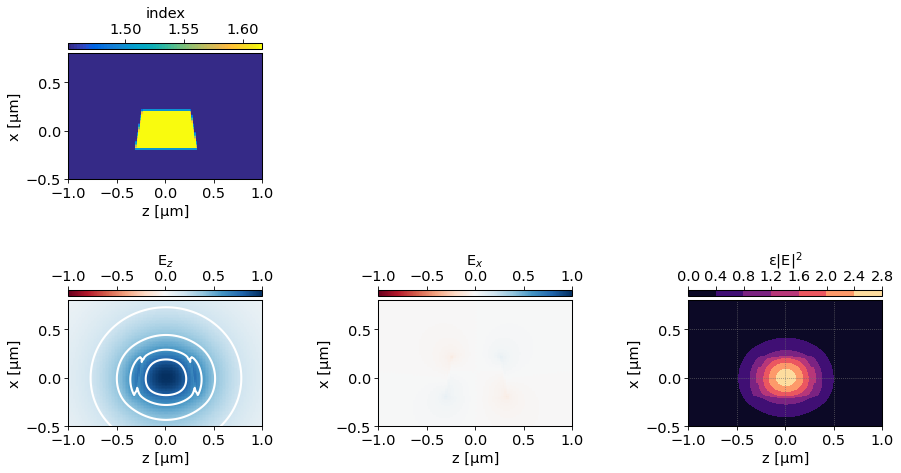

In [87]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])

#ax02 = fig.add_subplot(gs[0,2])

# plot index as a function of space
pc00 = ax00.pcolormesh(z,x,np.sqrt(ε),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
pc = [pc00,]

labels = ['index',
          'core_mat',
          'ε|E$_z$|$^2$',
         ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('z [μm]')
    a.set_ylabel('x [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(pc[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[:,:,0,:,mind] / E[:,:,0,:,mind].flatten()[np.argmax(np.abs(E[:,:,0,:,mind]))]
    eps_ei2 = ε[:,:] * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{z}$',
              'E$_{x}$',
#               'E$_{z}$',
              'ε|E|$^2$',
    ]

#     if F == "H":
#         F_norm = H[...,:,mind] / H[...,:,mind].flatten()[np.argmax(np.abs(H[...,:,mind]))]
#         labels = [
#                   'H$_{x}$',
#                   'H$_{y}$',
#     #               'H$_{z}$',
#                    'ϵ|E|$^2$',
#                  ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    pc10 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,2].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )
    c10 = ax[axind].contour(z,
                      x,
                      F_norm[:,:,2].real,
                      colors=colors,
                      levels=levels,
                      linewidths=lws,
                      vmin=vmin,
                      vmax=vmax,
                     )

    axind = 1 
    pc11 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,0].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )
    c11 = ax[axind].contour(z,
                          x,
                          F_norm[:,:,0].real,
                          colors=colors,
                          levels=levels,
                          linewidths=lws,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(z,
#                           x,
#                           F_norm[:,:,axind].real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    pc12 = ax[axind].contourf(z,x,eps_ei2,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    pc = [pc10,pc11,pc12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('z [μm]')
        a.set_ylabel('x [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(pc[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
# res = ms.compute_field_energy()

In [88]:
# plot settings
F = 'E'
n_modes = params['n_modes']
E = E2
ε = ε2
# contour plots settings
colors = 'w'
levels = [0.2,0.4,0.6,0.8]
lws = 2

z = params["z"]
x = params["x"]

xlim = -1,1
ylim = -0.3,0.5
figsize=(14,5 + 3*n_modes)

/home/dodd/miniconda3/envs/mp_dev/lib/python3.6/site-packages/ipykernel_launcher.py:117: UserWarning: No contour levels were found within the data range.


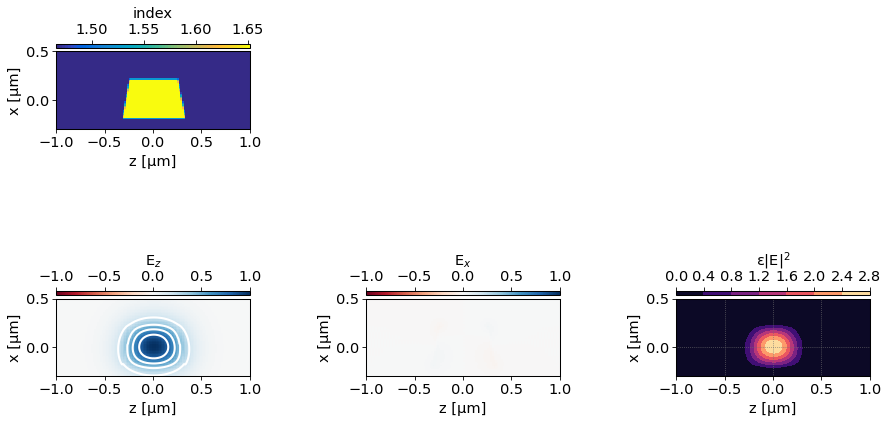

In [89]:
#### plot various computed fields for this instance ###
fig = plt.figure(figsize=figsize)
gs = GridSpec(n_modes+1,
              3,
              wspace=0.6,
              hspace=0.2,
             )

ax00 = fig.add_subplot(gs[0,0])

#ax02 = fig.add_subplot(gs[0,2])

# plot index as a function of space
pc00 = ax00.pcolormesh(z,x,np.sqrt(ε),label='index')

# plot binary variable detecting core material
# p01 = ax01.pcolormesh(x,y,mat_core_mask.T,cmap=cm.Greys,label='core_mat')

# ax = [ax00,ax01,]
# p = [p00,p01,]
ax = [ax00,]
pc = [pc00,]

labels = ['index',
          'core_mat',
          'ε|E$_z$|$^2$',
         ]


for aind,a in enumerate(ax):
    if xlim:
        a.set_xlim(xlim)
    if ylim:
        a.set_ylim(ylim)
    a.set_aspect('equal')
    a.set_xlabel('z [μm]')
    a.set_ylabel('x [μm]')
    divider = make_axes_locatable(a)
    cax = divider.append_axes("top", size="5%", pad=0.05)
    cb = plt.colorbar(pc[aind],
                 cax=cax,
                 orientation="horizontal",
                )
    cb.set_label(labels[aind])#,labelpad=-1)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

####################################################################


for mind in range(n_modes):
    ax =  [fig.add_subplot(gs[1+mind,0]),
            fig.add_subplot(gs[1+mind,1]),
            fig.add_subplot(gs[1+mind,2]),
          ]
    
    
#     F_norm = E[...,:,mind] / E[...,zind,:,mind].flatten()[np.argmax(np.abs(E[...,zind,:,mind]))]
    F_norm = E[:,:,0,:,mind] / E[:,:,0,:,mind].flatten()[np.argmax(np.abs(E[:,:,0,:,mind]))]
    eps_ei2 = ε[:,:] * ( np.abs(F_norm[:,:,0])**2 + np.abs(F_norm[:,:,1])**2 + np.abs(F_norm[:,:,2])**2 )
    labels = [
              'E$_{z}$',
              'E$_{x}$',
#               'E$_{z}$',
              'ε|E|$^2$',
    ]

#     if F == "H":
#         F_norm = H[...,:,mind] / H[...,:,mind].flatten()[np.argmax(np.abs(H[...,:,mind]))]
#         labels = [
#                   'H$_{x}$',
#                   'H$_{y}$',
#     #               'H$_{z}$',
#                    'ϵ|E|$^2$',
#                  ]
    
    # plot Fx, Fy, Fz and ϵ|E|^2 
    vmax = np.abs(F_norm.real).max()
    vmin = -1 * np.abs(F_norm.real).max() #E_norm.real.min()

    


    axind = 0 
    pc10 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,2].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )
    c10 = ax[axind].contour(z,
                      x,
                      F_norm[:,:,2].real,
                      colors=colors,
                      levels=levels,
                      linewidths=lws,
                      vmin=vmin,
                      vmax=vmax,
                     )

    axind = 1 
    pc11 = ax[axind].pcolormesh(z,
                          x,
                          F_norm[:,:,0].real,
                          cmap=cm.RdBu,
                          vmin=vmin,
                          vmax=vmax,
                         )
    c11 = ax[axind].contour(z,
                          x,
                          F_norm[:,:,0].real,
                          colors=colors,
                          levels=levels,
                          linewidths=lws,
                          vmin=vmin,
                          vmax=vmax,
                         )

#     axind = 2
#     p12 = ax[axind].pcolormesh(z,
#                           x,
#                           F_norm[:,:,axind].real,
#                           cmap=cm.RdBu,
#                           vmin=vmin,
#                           vmax=vmax,
#                          )
    
    axind = 2
    pc12 = ax[axind].contourf(z,x,eps_ei2,cmap=cm.magma)







    ## format and label plots

#     ax = [ax10,ax11,ax12,ax13,ax20,ax21,ax22]
    pc = [pc10,pc11,pc12]
    




    for aind,a in enumerate(ax):
        if xlim:
            a.set_xlim(xlim)
        if ylim:
            a.set_ylim(ylim)
        a.set_aspect('equal')
        a.set_xlabel('z [μm]')
        a.set_ylabel('x [μm]')
        divider = make_axes_locatable(a)
        cax = divider.append_axes("top", size="5%", pad=0.05)
        cb = plt.colorbar(pc[aind],
                     cax=cax,
                     orientation="horizontal",
                    )
        cb.set_label(labels[aind])#,labelpad=-1)
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')

# print field energy integrals
# res = ms.compute_field_energy()

# DC fields

## electrostatics.py

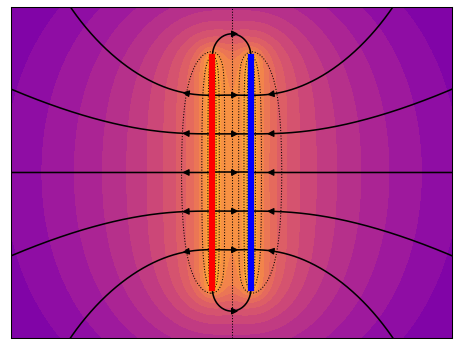

In [2]:
# line-line example
"""Plots field lines for two line charges."""
import electrostatics
from electrostatics import LineCharge
from electrostatics import ElectricField, Potential
from electrostatics import finalize_plot

# pylint: disable=invalid-name

XMIN, XMAX = -200, 200
YMIN, YMAX = -150, 150
ZOOM = 35
XOFFSET = 0

electrostatics.init(XMIN, XMAX, YMIN, YMAX, ZOOM, XOFFSET)

# Set up the charges, electric field, and potential
a = 3
charges = [LineCharge(1, [-0.5, -a], [-0.5, a]),
           LineCharge(-1, [0.5, -a], [0.5, a])]
field = ElectricField(charges)
potential = Potential(charges)

# Create the flux points manually
fluxpoints = []
fluxpoints += list([-0.51, y] for y in np.linspace(-a, a, 7)[1:-1])
fluxpoints += list([-0.49, y] for y in np.linspace(-a, a, 7)[1:-1])
fluxpoints += [[-0.5, -a-0.01], [-0.5, a+0.01]]

# Create the field lines
fieldlines = []
for x in fluxpoints:
    fieldlines.append(field.line(x))
fieldlines.append(field.line([10, 0]))

# Plotting
plt.figure(figsize=(6, 4.5))
field.plot()
potential.plot()
for fieldline in fieldlines:
    fieldline.plot()
for charge in charges:
    charge.plot()
finalize_plot()
plt.show()

In [13]:
python -m ipykernel install --user --name myenv --display-name "Python (myenv)"# line-line example
"""Plots field lines for two line charges."""
import electrostatics
from electrostatics import LineCharge
from electrostatics import ElectricField, Potential
from electrostatics import finalize_plot

# pylint: disable=invalid-name

XMIN, XMAX = -200, 200
YMIN, YMAX = -150, 150
ZOOM = 35
XOFFSET = 0

electrostatics.init(XMIN, XMAX, YMIN, YMAX, ZOOM, XOFFSET)

# Set up the charges, electric field, and potential
a = 1  # length of line charges
w = 1  # width of electrodes
dw = 0.2 # spacing between line charges used to make up electrodes
d = 3   # distance between line charges
charges = [LineCharge(1, [-0.5*d, -a], [-0.5*d, a]),
           LineCharge(-1, [0.5*d, -a], [0.5*d, a]),
           LineCharge(1, [-0.5*d-w/4, -a], [-0.5*d-w/4, a]),
           LineCharge(-1, [0.5*d+w/4, -a], [0.5*d+w/4, a]),
           LineCharge(1, [-0.5*d-w/2, -a], [-0.5*d-w/2, a]),
           LineCharge(-1, [0.5*d+w/2, -a], [0.5*d+w/2, a]),
           LineCharge(1, [-0.5*d-3*w/4, -a], [-0.5*d-3*w/4, a]),
           LineCharge(-1, [0.5*d+3*w/4, -a], [0.5*d+3*w/4, a]),
           LineCharge(1, [-0.5*d-w, -a], [-0.5*d-w, a]),
           LineCharge(-1, [0.5*d+w, -a], [0.5*d+w, a]),
          ]
field = ElectricField(charges)
potential = Potential(charges)

# # Create the flux points manually
# fluxpoints = []
# fluxpoints += list([-0.51, y] for y in np.linspace(-a, a, 7)[1:-1])
# fluxpoints += list([-0.49, y] for y in np.linspace(-a, a, 7)[1:-1])
# fluxpoints += [[-0.5, -a-0.01], [-0.5, a+0.01]]

# # Create the field lines
# fieldlines = []
# for x in fluxpoints:
#     fieldlines.append(field.line(x))
# fieldlines.append(field.line([10, 0]))

# # Plotting
# plt.figure(figsize=(6, 4.5))
# field.plot()
# potential.plot()
# for fieldline in fieldlines:
#     fieldline.plot()
# for charge in charges:
#     charge.plot()
# finalize_plot()
# plt.show()

field.plot()

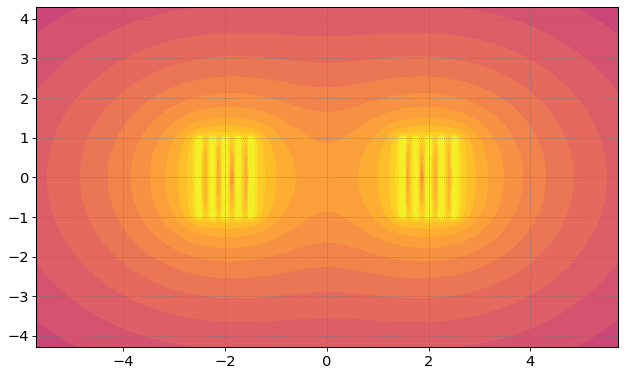

In [14]:
field.plot()

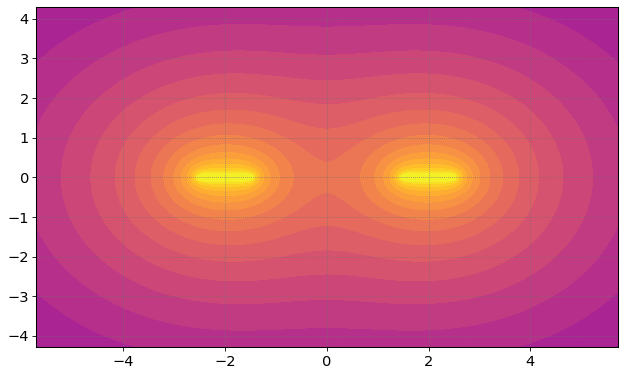

In [30]:
# line-line example
"""Plots field lines for two line charges."""
import electrostatics
from electrostatics import LineCharge
from electrostatics import ElectricField, Potential
from electrostatics import finalize_plot

# pylint: disable=invalid-name

XMIN, XMAX = -200, 200
YMIN, YMAX = -150, 150
ZOOM = 35
XOFFSET = 0

electrostatics.init(XMIN, XMAX, YMIN, YMAX, ZOOM, XOFFSET)

# Set up the charges, electric field, and potential
a = 1  # length of line charges
w = 1  # width of electrodes
dw = 0.2 # spacing between line charges used to make up electrodes
d = 3   # distance between line charges
charges = [LineCharge(1, [0.5*d+w, 0], [0.5*d, 0]),
           LineCharge(-1, [-0.5*d-w, 0], [-0.5*d, 0]),
          ]
field = ElectricField(charges)
potential = Potential(charges)
field.plot()

## fenics

In [ ]:
from fenics import *

# Create mesh and define function space
mesh = UnitSquareMesh(8, 8)
V = FunctionSpace(mesh, 'P', 1)

# Define boundary condition
u_D = Expression('1 + x[0]*x[0] + 2*x[1]*x[1]', degree=2)

def boundary(x, on_boundary):
    return on_boundary

bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(-6.0)
a = dot(grad(u), grad(v))*dx
L = f*v*dx

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Plot solution and mesh
plot(u)
plot(mesh)

# Save solution to file in VTK format
vtkfile = File('poisson/solution.pvd')
vtkfile << u

# Compute error in L2 norm
error_L2 = errornorm(u_D, u, 'L2')

# Compute maximum error at vertices
vertex_values_u_D = u_D.compute_vertex_values(mesh)
vertex_values_u = u.compute_vertex_values(mesh)
import numpy as np
error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))

# Print errors
print('error_L2  =', error_L2)
print('error_max =', error_max)

# Hold plot
interactive()

# Material parameters for NLO calculation

In [31]:

###########################################
#
#     Alumina material coefficients
#
###########################################

#### χ^(3) #####
 
# n_2 for crystalline sapphire, from OEWave Paper
# Ilchenko,...,Maleki et al., "Generation of Kerr frequency combs in a sapphire whispering gallery mode microresonator Optical Engineering 53 (12), 122607 (2014)
# https://doi.org/10.1117/1.OE.53.12.122607
n2_al2o3 = 2.8e-16 * u.cm**2 / u.watt 


##### ϵ_s (low freq dielectric constant)  #####

# for crystalline and polycrystalline sapphire measured at 1kHz, from:
# Fontanella et al, "Low‐frequency dielectric constants of α‐quartz, sapphire, MgF2, and MgO", J. Appl. Phys. 45, 2852 (1974)
# https://doi.org/10.1063/1.1663690

ϵ_s_al2o3_e = 11.59 # crystalline, e-axis
ϵ_s_al2o3_o = 9.4   # crystalline, o-axis
ϵ_s_al2o3 = 11.15 # polycrystalline



###########################################
#
#     Silica material coefficients
#
###########################################

#### χ^(3) #####
 
# "DC Kerr" or Quadratic EO coeff: χ^(3)(-ω;ω,0,0) from:
# Liu, Digonnet and Kino, "Measurement of the DC Kerr and electrostrictive phase modulation in silica"  
# JOSA B, 18 (2), (2001). https://doi.org/10.1364/JOSAB.18.000187
χ3_silica = 1.9e-22 * u.meter**2 / u.V**2


##### ϵ_s (low freq dielectric constant)  #####

# haven't found good citation, see for example
# https://www.accuratus.com/fused.html

ϵ_s_silica = 3.82 # fused silica, 300K


In [126]:
which_band=1
ng_geom = 1/ms.compute_one_group_velocity_component(mp.Vector3(0,1,0),which_band)
E_obj = ms.compute_energy_in_objects(ms.geometry)
n_obj = np.array([np.sqrt(obj.material.epsilon_diag[2]) for obj in ms.geometry])
ng_obj = np.array([obj.material.ng for obj in ms.geometry])

AttributeError: 'Medium' object has no attribute 'ng'

In [127]:
ms.compute_energy_in_dielectric(1.6**2, 1.8**2)

0.0

In [128]:
E_obj

0.0

In [129]:
ms.solve_kpoint(mp.Vector3(0,neff[0]*p["ω"],0))

solve_kpoint (0,2.99866,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 1 iterations.
freqs:, 2, 0, 2.99866, 0, 2.99866, 2


In [130]:
neff[0]*p["ω"]

2.9986642863008264

In [131]:
ms.get_dpwr(1)

D-energy-components:, 2, 1, 0.000553096, 0.0222746, 0.977172


MPBArray([[0.00025135, 0.00025195, 0.00025372, ..., 0.00025605,
           0.00025372, 0.00025196],
          [0.00025227, 0.00025289, 0.00025407, ..., 0.00025712,
           0.00025408, 0.00025288],
          [0.00025427, 0.0002545 , 0.00025659, ..., 0.00025889,
           0.0002566 , 0.00025451],
          ...,
          [0.0002567 , 0.00025752, 0.00025879, ..., 0.0002617 ,
           0.00025881, 0.00025752],
          [0.00025378, 0.00025402, 0.0002561 , ..., 0.0002584 ,
           0.00025609, 0.00025402],
          [0.00025203, 0.00025264, 0.00025383, ..., 0.00025687,
           0.00025384, 0.00025264]])

In [132]:
1/ms.compute_one_group_velocity_component(mp.Vector3(0,1,0),1)

1.5980410762798443

In [135]:
ms.geometry[0].material.ng

AttributeError: 'Medium' object has no attribute 'ng'

In [137]:
geom[0].material.ng

1.71636